In [28]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
from astropy.table import vstack
from astropy.modeling import models
import corner
import pickle
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit

In [30]:
def load_data(filename='radio_lightcurve.dat'):
    data = ascii.read(filename)
    
    return data

data = load_data()

# Make a plot of the radio lightcurve
Make a log-log plot of the flux density as a function of time. Make sure to modularise your code so that we can re-use parts of it later on. For bonus points use different markers for each telescope, and use a colour scale to denote the observation frequency.

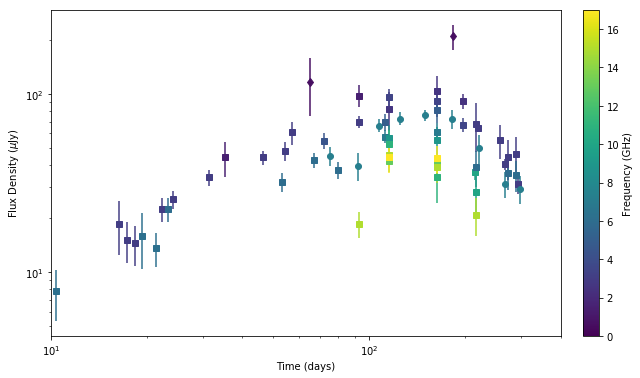

In [51]:
def plot_data(ax, sm, data, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':'s', 'ATCA':'o', 'GMRT':'d'}
    
    
    for row in data:
        freq = row['frequency']
        colorval = sm.to_rgba(freq)
        
        telescope = row['telescope']
        marker = telescope_marker_dict[telescope]
        
        if scaled:
            flux = row['scaled_flux']
            rms = row['scaled_rms']
        else:
            flux = row['flux']
            rms = row['rms']
        
        ax.errorbar(row['delta_t'], flux, rms, linestyle='', marker=marker, c=colorval, **kwargs)
    return

def cmap_setup(cmap='viridis', min_freq=0, max_freq=17):
    freq_cmap = plt.cm.get_cmap(cmap)
    min_freq = 0
    max_freq = 17
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []
    
    return sm
    

def make_plot(data, scaled=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    sm = cmap_setup()
    plot_data(ax, sm, data, scaled=scaled)
    
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label('Frequency (GHz)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')
    
    ax.set_xlim(10,400)
    
make_plot(data)

# Determining the spectral index
Write a function to take a subset of the data and calculate the spectral index and its uncertainty. Using multi-band observation at 162 days post-merger calculate the spectral index.

In [35]:
def alpha_calc(data):
    freqs = data['frequency']
    flux = data['flux']
    errs = data['rms']
    
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1]
    alpha_err = np.sqrt(np.diag(pcov))[1]
    
    return alpha, alpha_err

## Scaling the data based on the spectral Index
Write a function to take the observed data and scale it to a specific frequency based on an estimated spectral index. Don't forget to include uncertainties! You should add two columns to your data table called "scaled_flux" and "scaled_rms"

In [42]:
def scale_data(data, alpha, alpha_err, ref_freq=3.0):
    f_scale = (ref_freq/data['frequency'])**alpha
    rms_scale = np.abs(f_scale*np.log(ref_freq/data['frequency'])*alpha_err)
    
    scaled_flux = data['flux'] * f_scale
    scaled_rms = np.abs(scaled_flux) * np.sqrt((data['rms']/data['flux'])**2 + (rms_scale/f_scale)**2)
    
    data['scaled_flux'] = scaled_flux
    data['scaled_rms'] = scaled_rms
    
    return data

Modify your plot_data() and make_plot() functions to add a keyword parameter "scaled" that is by default False. If scaled=True, plot_data() should plot the scaled data instead of the observed data.

Scale the data to 3 GHz based on your estimated spectral index and associated uncertainty, then plot the scaled lightcurve

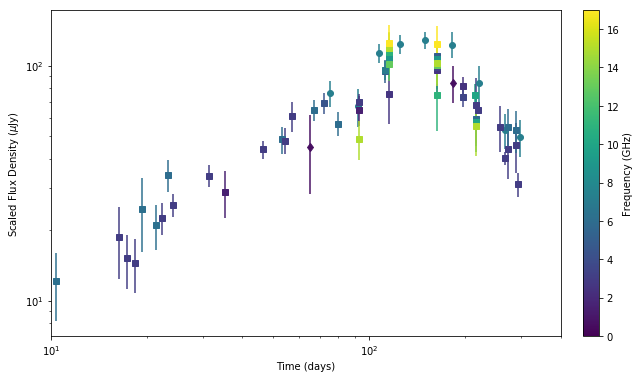

In [53]:
data = scale_data(data, -0.6,0.05)
make_plot(data, scaled=True)

We now want to characterise the radio lightcurve. You should be able to see that it initially rises according to a power law, peaks somewhere between 100 and 200 days post-merger and then declines according to a different power law.

However, when we published the first paper demonstrating evidence of a turnover we only had observations up to 200 days post-merger. We will now determine evidence for a turnover using that subset of data.

First, plot the data up to 200 days post-merger by creating a new table called tdata with the data up to 200 days post-merger and using your make_plot() function

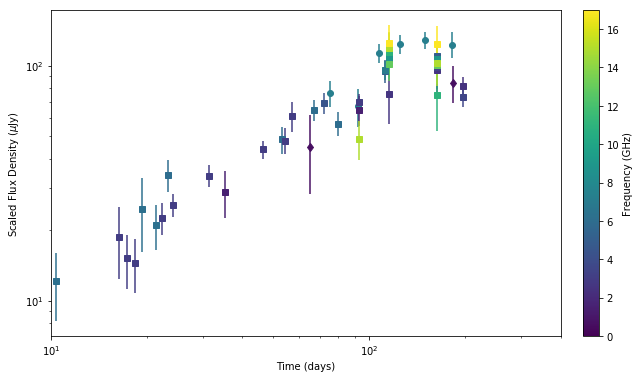

In [54]:
tdata = data[data['delta_t'] < 200]

make_plot(tdata, scaled=True)